In [1]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [2]:
import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

In [3]:
from tvm import te
A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")

In [4]:
type(A)

tvm.te.tensor.Tensor

In [5]:
A.shape

[128, 128]

我们可以通过一系列张量表达式来描述计算。这里的`te.compute`使用`te.compute(output_shape, fcompute)`这样的接口。fcompute函数描述了我们要如何计算给定索引的每个元素[i, j]的值。

`te_matmul`函数接受一个`te.Tensor`类型的对象，并返回矩阵乘法结果。请注意我们是如何根据A和B的输入shape构造计算的。`te_matmul`适用于具有不同输入shape的A和B。

In [6]:
def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    n = A.shape[0]
    m = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name="k")
    return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

In [7]:
C = te_matmul(A, B)

In [8]:
te.create_prim_func([A, B, C]).show()

下面是一个适用于任何维度的Relu函数

In [9]:
# Relu
def te_relu(A: te.Tensor) -> te.Tensor:
    # 允许任何形状的输入
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")

下面尝试不同纬度和shape

In [10]:
X1 = te.placeholder((10,), name="X1", dtype="float32")
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()

In [11]:
X2 = te.placeholder((10, 20), name="X1", dtype="float32")
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2]).show()

te API允许我们做的另一件事是组合操作并创建“融合(fused)”算子。例如，我们可以将matmul的结果再次应用relu

In [12]:
C = te_matmul(A, B)
D = te_relu(C)

可以通过只传递感兴趣的输入和输出值，跳过中间值来创建一个 TensorIR 函数。 这将导致 matmul 的结果被分配为 TensorIR 函数中的临时空间

In [13]:
te.create_prim_func([A, B, D]).show()

还可以将中间结果C传递到参数列表中。在这种情况下，TensorIR函数希望我们也从调用方传入C。通常我们**建议只传入输入和输出**，这样我们就可以在里面进行更高级的融合

In [14]:
# 在外面把C的内存开好传进去
te.create_prim_func([A, B, C, D]).show()

对于多个TensorIR函数，通过计算图进行连接，首先创建一个`block builder`，借助它来帮助我们逐步构建一个`relax.Function`

In [15]:
A = relax.Var("A", (128, 128), relax.DynTensorType(2, "float32"))
B = relax.Var("B", (128, 128), relax.DynTensorType(2, "float32"))

bb = relax.BlockBuilder()

with bb.function("main"):
  with bb.dataflow():
    C = bb.emit_te(te_matmul, A, B)
    D = bb.emit_te(te_relu, C)
    R = bb.emit_output(D)
  bb.emit_func_output(R, params=[A, B])

MyModule = bb.get()
MyModule.show()

BlockBuilder带有与Relax函数中相应的作用域。例如，`bb.dataflow()`创建一个dataflow block，其中所有对BlockBuilder的调用都处在dataflow block的作用域中，每个中间结果都是`relax.Var`，对应一个存储计算结构的变量，DataflowVar表示该变量是dataflow block和计算图内的中间步骤

In [16]:
type(C)

tvm.relax.expr.DataflowVar

In [17]:
isinstance(C, relax.Var)

True

`bb.emit_te`做了如下的事情
+ 为A和B创建一个输入`te.placeholder`
+ 通过`te_matmul`函数运行它们
+ 调用`te.create_prim_func`来创建一个TensorIR函数
+ 通过`call_tir`生成对函数的调用
可以通过`bb.emit_output`创建每个dataflow block的输出变量，即可以在dataflow block之外引用的变量

最后，函数输出由`bb.emit_func_output`标记。 我们只能在每个函数作用域内调用一次emit_func_output

大多数机器学习框架都带有计算图抽象，其中**每个节点对应一个操作，边对应它们之间的依赖关系**。我们将采用PyTorch模型，获取PyTorch原生格式的计算图，并将其转换为IRModule

In [18]:
# 继承nn.Module
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.weight = nn.Parameter(torch.randn(128, 128))

  def forward(self, x):
    x = torch.matmul(x, self.weight)
    x = torch.relu(x)
    return x

下面使用TorchFx来表示来自PyTorch的模型的计算图，并将其转化为IRModule

In [19]:
model = MyModel()

fx_module = fx.symbolic_trace(model)
type(fx_module)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

In [20]:
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7fae1ada1b20>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7fae1ada1b20>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


对于PyTorch来说，weight本身是已知的，不是未知的输入（X），其中可能包含一些优化的空间，需要分开标注

整体的翻译逻辑流程如下
+ 创建一个node_map，将`fx.Node`映射到相应的`relax.Var`，该`relax.Var`代表IRModule中已翻译的节点
+ 以拓扑顺序迭代FX图中的节点
+ 给定映射输入，获取节点的映射输出

In [21]:
def map_param(param: nn.Parameter):
    ndim = len(param.data.shape)
    return relax.const(
        param.data.cpu().numpy(), relax.DynTensorType(ndim, "float32")
    )

def fetch_attr(fx_mod, target: str):
    """Helper function to fetch an attr"""
    target_atoms = target.split('.')
    attr_itr = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

# 给定fx module，将其转化为IR Module
def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            # 这个列表已经进行好拓扑排序
            for node in fx_mod.graph.nodes:
                if node.op == "placeholder":
                    # create input placeholder
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(
                        node.target, shape, relax.DynTensorType(len(shape), "float32")
                    )
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr":
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function":
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        # output and finalize the function
        bb.emit_func_output(output, fn_inputs)
    return bb.get()

下面没有在from_fx函数中定义函数映射，通过映射提供每个torch function的翻译规则

In [22]:
def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(
    fx_module,
    input_shapes = [(1, 128)],
    call_function_map = {
      torch.matmul: map_matmul,
      torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

In [23]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

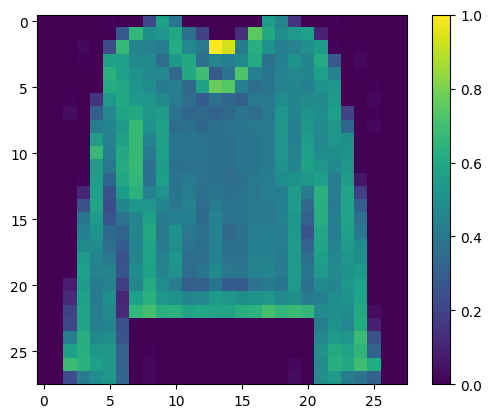

Class: Pullover


In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

可以通过如下方式构建其PyTorch模型

In [28]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear0 = nn.Linear(784, 128, bias=True)
    self.relu = nn.ReLU()
    self.linear1 = nn.Linear(128, 10, bias=True)
  
  def forward(self, x):
    x = self.linear0(x)
    x = self.relu(x)
    x = self.linear1(x)
    return x

In [29]:
import pickle as pkl

mlp_model = MLP()

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params["b1"])

In [30]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])

Torch Prediction: Pullover


让我们尝试通过为相应的`nn.Module`定义映射函数来从FX转换。 在这里，我们**重用了来自TVM TOPI(TVM operator inventory)的预定义TE库，而不是定义我们自己的张量表达式**
+ `topi.nn.dense(x, w)`执行转置矩阵乘法`x @ w.T`
+ `topi.add`执行广播加法

In [31]:
from tvm import topi


def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)


MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    },
)

MLPModule.show()

In [32]:
ex = relax.vm.build(MLPModule, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Pullover


在大多数机器学习框架中，有时先转换为更高一级的内置的原始算子会更有帮助。下面的代码块给出了一个例子来做到这一点，下面展示了我们使用哪些内置的算子将模型导入为IRModule后的结果。这些内置算子是比TensorIR函数更高级别的抽象。我们可以有不同的机会将这些原始算子进一步转换为库函数或TensorIR函数

In [34]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit(relax.op.dense(x, w))
    return bb.emit(relax.op.add(y, b))

MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op,
    },
)

MLPModuleHighLevel.show()